霍夫变换的基本原理：将直线的方程转换成极坐标形式
- 原始形式： y = ax + b
- 极坐标形式：r = x*cos(theta) + y*sin(theta)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


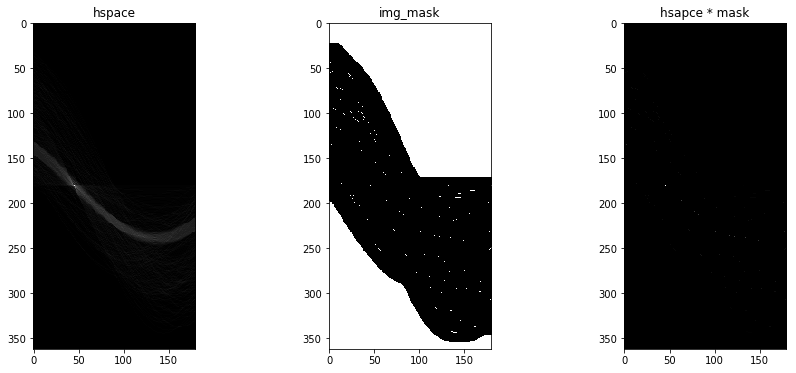

accumulator array shape: (362, 180)
bins array shape: (362,)


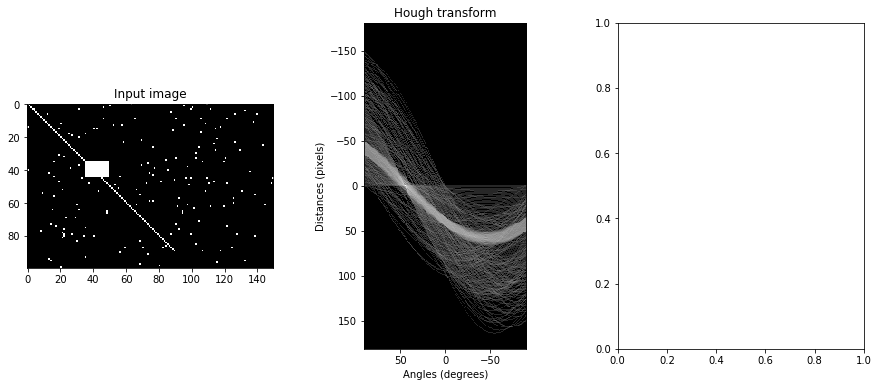

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.ndimage as ndi
%matplotlib inline

def hough_line(img, theta=None, min_distance=9, min_angle=10, peak_threshold=None, debug=True):
    """
    参数
    ---
    img: 2D ndarray 
        图片数据，边缘检测后的二值图像
    theta：1D ndarray of double，弧度
        经过一点的直线有无数条，这个参数定义了计算直线时用哪些角度，与哪个轴的夹角？
        默认在 [-pi/2, pi/2] 之间平均地取 180 个值，取值的间隔越小，最后计算出来的 angle 精度越高
    min_distane: int？
        端点距离小于该距离的直线认为是同一条直线
    min_angle：float ？
        小于该角度的直线认为是同一条直线
    peak_threshold: float
        过滤掉 hspace 上小于 peak_threshold 的点
        默认为：0.5 * max(hspace)
    
    返回结果
    ------
    hspace：2D ndarray of uint64
        霍夫变换后的累加图
    angles：1D ndarray
        直线的角度，弧度
    distances：1d ndarray
        原点到检测到的直线的垂直距离
    """
    if theta is None:
        theta = np.linspace(-np.pi / 2, np.pi / 2, 180)
        
    # 计算 theta 角度的 cos 和 sin 值
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    # 计算累加矩阵 accumulator array
    # 为什么要 *2：方便可视化?
    max_distance = int(2 * np.ceil(np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)))
    # 为什么需要 offset：方便可视化?
    offset = max_distance / 2
    
    # 在 hough 空间中 y 轴表示距离 r，x 轴表示角度的数量
    accum = np.zeros((max_distance, theta.shape[0]), dtype=np.uint64)
    
    bins = np.linspace(-max_distance / 2.0, max_distance / 2.0, max_distance)
    
    # 获得原始图像中的非 0 像素的索引
    x_idxs, y_idxs = np.nonzero(img)
    
    nidxs = y_idxs.shape[0] # x，y 的索引 shape 是一样的
    nthetas = theta.shape[0]
    
    # 在每一个非 0 点，有 nthetas 条直线经过该点
    # 计算原点到每一条直线的垂直距离 r
    for i in range(nidxs):
        x, y = x_idxs[i], y_idxs[i]
        for j in range(nthetas):
            accum_idx = int(np.round((ctheta[j] * x + stheta[j] * y)) + offset)
            accum[accum_idx, j] += 1
    
    #
    # 提取 accum(hspace) 中的极值，获得直线参数
    #
    img = accum.copy()
    if peak_threshold is None:
        peak_threshold = 0.5 * np.max(accum)
    
    ycoords_size = 2 * min_distance + 1
    xcoords_size = 2 * min_angle + 1
    
    # 每一列、每一行上保留多少个前多少个最大值
    img_max = ndi.maximum_filter1d(img, size=ycoords_size, axis=0,
                                   mode='constant', cval=0)
    img_max = ndi.maximum_filter1d(img_max, size=xcoords_size, axis=1,
                                   mode='constant', cval=0)
    
    mask = (img == img_max)
    img *= mask
    img_t = img > peak_threshold
    
    print(img_t)
    # TODO: https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/peak.py#L242
    
    if debug:
        plot_imgs([accum, mask, img],
                 ['hspace', 'img_mask', 'hsapce * mask'])
        
    if debug:
        print("accumulator array shape: %s" % str(accum.shape))
        print("bins array shape: %s" % str(bins.shape))
    
    return accum, theta, bins

def plot_imgs(imgs, names):
    assert len(imgs) == len(names)
    
    fig, axes = plt.subplots(1, len(imgs), figsize=(15, 6))
    ax = axes.ravel()
    
    for i in range(len(imgs)):
        ax[i].imshow(imgs[i], cmap=cm.gray)
        ax[i].set_title(names[i])
    plt.show()

if __name__ == "__main__":
    # 创建测试图像
    img = np.zeros((100, 150), dtype=bool)
    img[35:45, 35:50] = 1
    for i in range(90):
        img[i, i] = 1
    img += np.random.random(img.shape) > 0.99
    
    accum, theta, d = hough_line(img)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()
    ax[0].imshow(img, cmap=cm.gray)
    ax[0].set_title('Input image')
    
    ax[1].imshow(np.log(1+accum), 
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap=cm.gray)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distances (pixels)')

    
    plt.show()

参考：
- https://sikasjc.github.io/2018/04/20/Hough/
- https://github.com/scikit-image/scikit-image/blob/master/skimage/transform/hough_transform.py#L8
- https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/peak.py
- https://github.com/scikit-image/scikit-image/blob/master/skimage/transform/_hough_transform.pyx
- https://github.com/scikit-image/scikit-image/blob/master/skimage/transform/hough_transform.py#L224
- http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html#sphx-glr-download-auto-examples-edges-plot-line-hough-transform-py